In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np

class HMSSpectrogramDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file (train.csv).
            spectrogram_dir (string): Directory with all the .parquet files.
            transform (callable, optional): Optional transform to be applied
                on a sample (e.g., resizing, normalization).
        """
        self.data = pd.read_csv(csv_file)
        self.spectrogram_dir = spectrogram_dir
        self.transform = transform

        # The target columns (the votes for each class)
        self.target_cols = [
            'seizure_vote', 'lpd_vote', 'gpd_vote',
            'lrda_vote', 'grda_vote', 'other_vote'
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 1. Get row information
        row = self.data.iloc[idx]
        spec_id = int(row['spectrogram_id'])
        offset = int(row['spectrogram_label_offset_seconds'])

        # 2. Construct file path
        file_path = f"{self.spectrogram_dir}/{spec_id}.parquet"

        # 3. Load the specific parquet file
        # Note: In production, you might want to cache this or use a custom loader
        # because reading Parquet repeatedly can be slow.
        full_spectrogram = pd.read_parquet(file_path)

        # 4. Slice the data based on the offset
        # The spectrogram time starts at 0. We need the data starting at 'offset'.
        # The competition usually assumes a 10-minute window (600 seconds).
        # Since the rows in the parquet file typically represent 2 seconds each (0.5Hz),
        # we need to be careful with indexing.
        # *CHECK YOUR DATA*: Usually, the 'time' column in parquet aligns with offset.

        # Select rows where 'time' is between offset and offset + 600
        start_time = offset
        end_time = offset + 600

        # Filter the dataframe for the specific window
        window_df = full_spectrogram.loc[
            (full_spectrogram['time'] >= start_time) &
            (full_spectrogram['time'] < end_time)
        ]

        # Drop the 'time' column as it's not a feature for the CNN
        spec_data = window_df.drop(columns=['time']).values

        # 5. Handle missing values (NaNs are common in this dataset)
        # Replacing with 0 or the mean is standard.
        # Log transformation is also very common for spectrograms to normalize peaks.
        spec_data = np.nan_to_num(spec_data, nan=0.0)
        spec_data = np.log1p(spec_data) # Log transform acts as normalization

        # 6. Formatting for CNN: (Channels, Height, Width)
        # Current shape: (Time_Steps, Frequencies) -> e.g., (300, 400)
        # CNN expects: (1, 300, 400)
        spec_tensor = torch.tensor(spec_data, dtype=torch.float32).unsqueeze(0)

        # 7. Get the labels (targets)
        # Normalize votes to probabilities (sum to 1) if they aren't already
        votes = row[self.target_cols].values.astype(np.float32)
        total_votes = votes.sum()
        if total_votes > 0:
            probabilities = votes / total_votes
        else:
            # Fallback if no votes (unlikely in clean data)
            probabilities = np.zeros_like(votes)

        target = torch.tensor(probabilities, dtype=torch.float32)

        if self.transform:
            spec_tensor = self.transform(spec_tensor)

        return spec_tensor, target

print("Dataset Class Initialized")

# Usage Example:
# dataset = HMSSpectrogramDataset(csv_file='train.csv', spectrogram_dir='./train_spectrograms')
# loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Dataset Class Initialized


In [2]:
import torch
import torch.nn as nn
import timm # PyTorch Image Models library - standard for Kaggle

class HybridSpectrogramModel(nn.Module):
    def __init__(self, num_classes=6, d_model=256, nhead=4, num_layers=2):
        super().__init__()

        # 1. The CNN Backbone (Feature Extractor)
        # We use EfficientNet-B0 because it's lightweight.
        # 'features_only=True' is CRITICAL. It removes the final pooling/classifier layers.
        self.cnn = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            in_chans=1,             # Spectrograms are 1-channel (grayscale)
            features_only=True,     # Return intermediate feature maps
            out_indices=[4]         # Take the output from the last block
        )

        # EfficientNet-B0 output channels at the last block is 1280
        cnn_out_channels = 320

        # 2. Projection Layer
        # Compresses the CNN features to the Transformer size (d_model)
        self.projection = nn.Linear(cnn_out_channels, d_model)

        # 3. Positional Encoding (Learnable)
        # We assume a max sequence length (e.g., 32 chunks from the CNN)
        self.pos_embedding = nn.Parameter(torch.randn(1, 64, d_model))

        # 4. The Transformer Encoder (Lightweight!)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=0.1,
            batch_first=True # Expected input: (Batch, Seq_Len, Features)
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 5. Final Classifier
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # Input x shape: (Batch, 1, 128, 256) -> Example spectrogram size

        # --- CNN Stage ---
        # Output is a list of features. We took index [4], so we grab the last one.
        # Shape: (Batch, 1280, H_small, W_small)
        # Example: (Batch, 1280, 4, 8)
        features = self.cnn(x)[0]

        # --- Bridge Stage (The tricky part) ---
        # We want to treat the "Width" of the image as "Time".
        # We pool the "Height" (Frequency) because we want one vector per time step.

        # Average over the frequency dimension (Height)
        # Shape: (Batch, 1280, W_small)
        features = features.mean(dim=2)

        # Permute to put Time first for the Transformer? No, we used batch_first=True
        # Desired Shape: (Batch, Time_Steps, Features) -> (Batch, W_small, 1280)
        features = features.permute(0, 2, 1)

        # Project to d_model (e.g., 1280 -> 256)
        x = self.projection(features)

        # Add Positional Embedding (broadcasts across batch)
        # Ensure seq_len matches
        seq_len = x.shape[1]
        x = x + self.pos_embedding[:, :seq_len, :]

        # --- Transformer Stage ---
        # Shape: (Batch, Time_Steps, d_model)
        x = self.transformer(x)

        # --- Classification Stage ---
        # We can take the mean of all time steps (Global Average Pooling)
        # or just the last time step. Mean is usually more stable.
        x = x.mean(dim=1)

        # Output Logits
        output = self.classifier(x)
        return output

print("CNN Class Initialized")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

CNN Class Initialized


Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Epoch 1: New best validation loss (2.2032)! Model saved.
Epoch [1/10] | Train Loss: 1.1511 | Val Loss: 2.2032
Epoch 2: New best validation loss (0.7827)! Model saved.
Epoch [2/10] | Train Loss: 0.7571 | Val Loss: 0.7827
Epoch [3/10] | Train Loss: 0.3637 | Val Loss: 0.8295
Epoch 4: New best validation loss (0.1527)! Model saved.
Epoch [4/10] | Train Loss: 0.2650 | Val Loss: 0.1527
Epoch [5/10] | Train Loss: 0.4261 | Val Loss: 0.5431
Epoch [6/10] | Train Loss: 0.6653 | Val Loss: 0.3964
Epoch [7/10] | Train Loss: 0.4475 | Val Loss: 0.1923
Epoch [8/10] | Train Loss: 0.3905 | Val Loss: 0.1854
Epoch [9/10] | Train Loss: 0.2574 | Val Loss: 0.2001
Epoch [10/10] | Train Loss: 0.3763 | Val Loss: 0.1562
Training cycle with validation complete!


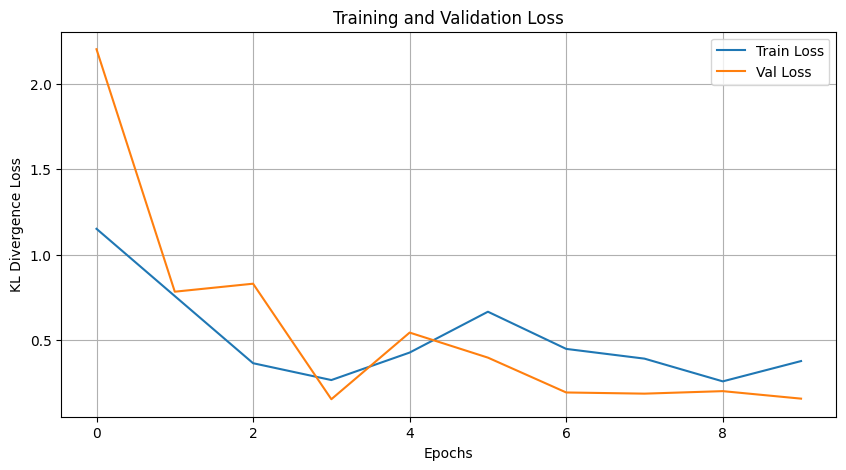

In [4]:
from torch.utils.data import DataLoader, Subset, random_split
import torch.optim as optim

# --- CONFIGURATION ---
NUM_SAMPLES = 100  # Total pool of data to draw from
TRAIN_RATIO = 0.8  # 80% for training, 20% for validation
BATCH_SIZE = 8
EPOCHS = 10        # Increased slightly to see the trend
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Initialize full dataset
full_dataset = HMSSpectrogramDataset(csv_file='/kaggle/input/hms-harmful-brain-activity-classification/train.csv', spectrogram_dir='/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms')

# 2. Subset first, then split
# This allows you to control the total data used (100, 500, etc.)
indices = np.arange(NUM_SAMPLES)
main_subset = Subset(full_dataset, indices)

train_size = int(TRAIN_RATIO * len(main_subset))
val_size = len(main_subset) - train_size

train_dataset, val_dataset = random_split(main_subset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Model, Loss, Optimizer
model = HybridSpectrogramModel(num_classes=6).to(DEVICE)
criterion = nn.KLDivLoss(reduction='batchmean') #Loss f'n
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- TRAINING & VALIDATION LOOP ---
best_val_loss = float('inf') # Initialize with infinity
# Initialize lists to store history
history = {'train_loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(torch.log_softmax(outputs, dim=1), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(torch.log_softmax(outputs, dim=1), targets)
            val_loss += loss.item()
    
    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)

    # Store the results
    history['train_loss'].append(avg_train)
    history['val_loss'].append(avg_val)
    
    # --- SAVE LOGIC ---
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), f'effnet-b0_{NUM_SAMPLES}_e{EPOCHS}_best.pth')
        print(f"Epoch {epoch+1}: New best validation loss ({avg_val:.4f})! Model saved.")
    # ------------------

    # --- SAVE CHECKPOINT --- #
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_val,
    }, f'effnet-b0_{NUM_SAMPLES}_e{EPOCHS}_checkpoint.pth')

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")


print("Training cycle with validation complete!")

# --- After the loop finishes, plot it ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
#Loading model for later
# 1. Recreate the model structure
loaded_model = HybridSpectrogramModel(num_classes=6)

# 2. Load the state dictionary
loaded_model.load_state_dict(torch.load('best_model.pth'))

# 3. Move to device and set to evaluation mode
loaded_model.to(DEVICE)
loaded_model.eval()
"""

In [5]:
def print_prediction_table(model, loader, device, num_samples=5):
    model.eval()
    classes = ['SZR', 'LPD', 'GPD', 'LRDA', 'GRDA', 'OTH']
    
    # Header
    header = f"{'Type':<10} | " + " | ".join([f"{c:<5}" for c in classes])
    print("\n" + "="*55)
    print("           MODEL PREDICTION SAMPLES")
    print("="*55)
    print(header)
    print("-" * 55)

    with torch.no_grad():
        # Get one batch
        inputs, targets = next(iter(loader))
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Get predictions and convert to probabilities
        logits = model(inputs)
        probs = torch.softmax(logits, dim=1)

        for i in range(min(num_samples, len(inputs))):
            true_str = " | ".join([f"{x:.2f}" for x in targets[i].cpu().numpy()])
            pred_str = " | ".join([f"{x:.2f}" for x in probs[i].cpu().numpy()])
            
            print(f"{'Actual':<10} | {true_str}")
            print(f"{'Predict':<10} | {pred_str}")
            print("-" * 55)

# Call the function
print_prediction_table(model, val_loader, DEVICE, num_samples=5)


           MODEL PREDICTION SAMPLES
Type       | SZR   | LPD   | GPD   | LRDA  | GRDA  | OTH  
-------------------------------------------------------
Actual     | 1.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
Predict    | 0.98 | 0.00 | 0.01 | 0.00 | 0.00 | 0.00
-------------------------------------------------------
Actual     | 0.60 | 0.00 | 0.40 | 0.00 | 0.00 | 0.00
Predict    | 0.63 | 0.00 | 0.32 | 0.00 | 0.00 | 0.05
-------------------------------------------------------
Actual     | 0.00 | 0.00 | 0.00 | 0.00 | 0.23 | 0.77
Predict    | 0.00 | 0.01 | 0.01 | 0.02 | 0.03 | 0.93
-------------------------------------------------------
Actual     | 0.00 | 0.00 | 0.00 | 1.00 | 0.00 | 0.00
Predict    | 0.02 | 0.05 | 0.00 | 0.89 | 0.00 | 0.03
-------------------------------------------------------
Actual     | 0.00 | 0.00 | 0.17 | 0.00 | 0.67 | 0.17
Predict    | 0.01 | 0.00 | 0.13 | 0.01 | 0.60 | 0.25
-------------------------------------------------------
